# Fetching Historical Data

In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import ipywidgets as widgets

In [30]:
# Fetch SP100 tickers from Wikipedia
url = 'https://en.wikipedia.org/wiki/S%26P_100'
tables = pd.read_html(url)
sp100_tickers = tables[2]['Symbol'].tolist()

# Fetch historical stock data
start_date = '2000-01-01'
end_date = '2023-07-30'

data = yf.download(sp100_tickers, start=start_date, end=end_date)['Adj Close'].dropna(how='all', axis=1)

[*********************100%***********************]  101 of 101 completed

1 Failed download:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [31]:
data

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,0.844004,NaN,8.327242,NaN,16.274673,838.573853,15.500000,44.614418,22.544767,4.468750,...,32.755486,5.358776,6.662700,34.991386,9.203342,NaN,16.908848,9.915335,14.378468,18.035822
2000-01-04 00:00:00+00:00,0.772846,NaN,8.089325,NaN,14.909397,795.712097,14.625000,41.202980,22.304417,4.096875,...,31.362469,5.290234,6.653029,33.882618,8.867660,NaN,16.362255,9.424319,13.840453,17.690361
2000-01-05 00:00:00+00:00,0.784155,NaN,8.074448,NaN,15.204177,797.602478,15.000000,42.620716,22.977398,3.487500,...,30.606272,5.277773,6.653029,35.480537,8.671843,NaN,16.908848,9.329284,13.557997,18.654772
2000-01-06 00:00:00+00:00,0.716296,NaN,8.356977,NaN,15.328290,821.933044,16.000000,43.329597,22.737041,3.278125,...,29.770491,5.470938,7.059174,35.480537,9.343210,NaN,16.822960,9.741101,13.705942,19.619169
2000-01-07 00:00:00+00:00,0.750226,NaN,8.446200,NaN,16.072987,883.452087,16.250000,48.203056,23.986860,3.478125,...,29.929684,6.112743,7.010829,34.632664,9.706868,NaN,16.698740,9.915335,14.741626,19.561590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-24 00:00:00+00:00,191.510086,137.853836,112.285446,308.309723,523.859985,58.654846,110.610001,226.708786,184.238617,128.800003,...,177.093948,499.107147,211.040695,178.165009,37.351601,238.411209,31.678310,44.733463,52.207142,101.116631
2023-07-25 00:00:00+00:00,192.374481,136.361496,110.629860,312.541382,525.340027,58.294708,113.000000,226.602844,180.338165,129.130005,...,179.203033,501.314789,209.688492,174.712204,36.019653,236.381042,31.920706,43.827621,52.164539,101.269966
2023-07-26 00:00:00+00:00,193.248825,136.621445,111.756439,311.478516,514.549988,59.219398,110.089996,226.506592,183.417969,128.149994,...,169.495544,498.439911,231.527985,174.428406,36.999584,234.806427,32.013931,44.752739,52.351341,100.704575


# Preprocessing data

In [32]:
# Calculate log returns
returns = data.pct_change().dropna().apply(lambda x: np.log(1 + x))

In [33]:
# Fill NaN values with mean return
returns = returns.fillna(returns.mean())

In [34]:
# Number of assets
n = len(returns.columns)

# Expected returns
mu = returns.mean().values

# Covariance matrix
Sigma = np.cov(returns, rowvar=False).astype(np.float64) 

In [35]:
# Estimate covariance matrix using Ledoit-Wolf shrinkage
cov_estimator = LedoitWolf()
cov_estimator.fit(returns)
Sigma = cov_estimator.covariance_

In [36]:
# Investor views
views = np.zeros(n)

# View uncertainty
view_uncertainty = np.eye(n) * 0.1

# Market equilibrium returns
market_equilibrium_returns = returns.mean().values

In [37]:
# Target expected return
target_return = 0.20

# Black Litterman

In [38]:
# Variable for the portfolio weights
w = cp.Variable(n)

# Portfolio expected return
expected_return = mu @ w

# Portfolio variance
variance = cp.quad_form(w, Sigma)

# Investor views
P = np.eye(n)
Q = views

# View uncertainty
Omega = view_uncertainty

# Market equilibrium returns
Pi = market_equilibrium_returns

# Black-Litterman model
tau = 0.1
Omega_inv = np.linalg.inv(Omega)
Sigma_inv = np.linalg.inv(Sigma)

# Posterior expected returns
posterior_return = cp.inv_pos(cp.inv_pos(tau * Sigma_inv) + P.T @ Omega_inv @ P) @ (cp.inv_pos(tau * Sigma_inv) @ Pi + P.T @ Omega_inv @ Q)

# Problem constraints
constraints = [
    cp.sum(w) == 1,  # Sum of weights equals 1
    expected_return >= target_return  # Target expected return constraint
]

# Problem objective
objective = cp.Minimize(variance)

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Optimal portfolio weights
optimal_weights = w.value

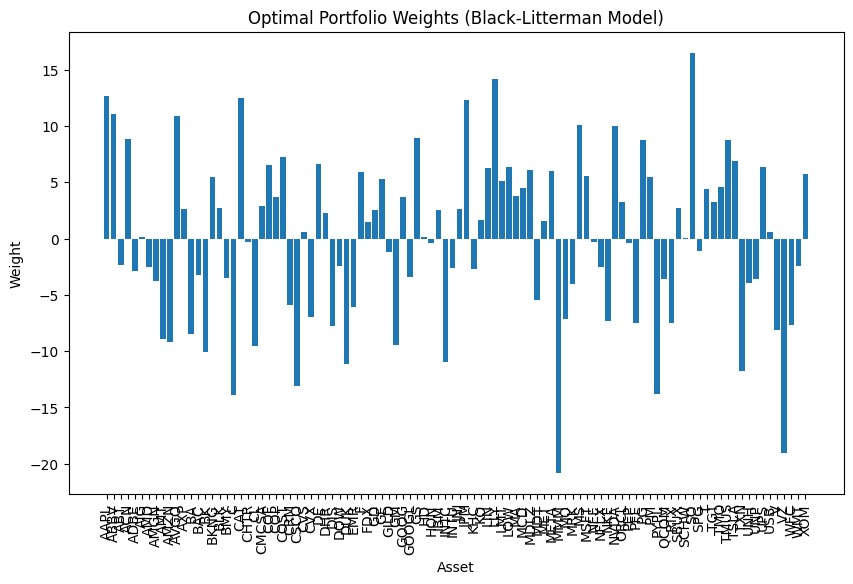

In [39]:
# Plot optimal portfolio weights
plt.figure(figsize=(10, 6))
plt.bar(returns.columns, optimal_weights)
plt.xlabel('Asset')
plt.ylabel('Weight')
plt.title('Optimal Portfolio Weights (Black-Litterman Model)')
plt.xticks(rotation=90)

plt.show()